In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
spark = SparkSession \
.builder \
.appName("mongodbtest1") \
.master("spark://10.1.174.144:7077")\
.config("spark.mongodb.read.uri", "mongodb://abhi_1:60000/shardDB.asofashion_2") \
.config("spark.mongodb.write.uri", "mongodb://abhi_1:60000/shardDB.asofashion_clean") \
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.13:10.2.2') \
.getOrCreate()

:: loading settings :: url = jar:file:/home/exouser/spark-3.2.4/assembly/target/scala-2.12/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/exouser/.ivy2/cache
The jars for the packages stored in: /home/exouser/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-82aab03e-7b75-4ae6-8773-d7af16a68279;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.13;10.2.2 in central
	found org.mongodb#mongodb-driver-sync;4.8.2 in central
	[4.8.2] org.mongodb#mongodb-driver-sync;[4.8.1,4.8.99)
	found org.mongodb#bson;4.8.2 in central
	found org.mongodb#mongodb-driver-core;4.8.2 in central
	found org.mongodb#bson-record-codec;4.8.2 in central
:: resolution report :: resolve 1267ms :: artifacts dl 9ms
	:: modules in use:
	org.mongodb#bson;4.8.2 from central in [default]
	org.mongodb#bson-record-codec;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-core;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-sync;4.8.2 from central in [default]
	org.mongodb.spark#mongo-spark-connecto

In [2]:
dataFrame = spark.read\
                 .format("mongodb")\
                 .option("connection.uri", "mongodb://abhi_1:60000/")\
                 .option("database", "shardDB")\
                 .option("collection", "asofashion_clean")\
                 .load()

In [4]:
dataFrame.count()

34620

In [6]:
dataFrame.take(1)

[Row(_id='6620448181245e02d8049917', brand_name='Truffle Collection Wide Fit', colour=nan, currency='USD', current_price=48.0, gender='female', previous_price=0.0, productCode=118785752, productType='Product', product_id=202829517, rrp=73.0, title='truffle collection wide fit chunky heeled sock boots in black')]

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
dataFrame.show(1)

+--------------------+--------------------+------+--------+-------------+------+--------------+-----------+-----------+----------+----+--------------------+
|                 _id|          brand_name|colour|currency|current_price|gender|previous_price|productCode|productType|product_id| rrp|               title|
+--------------------+--------------------+------+--------+-------------+------+--------------+-----------+-----------+----------+----+--------------------+
|6620448181245e02d...|Truffle Collectio...|   NaN|     USD|         48.0|female|           0.0|  118785752|    Product| 202829517|73.0|truffle collectio...|
+--------------------+--------------------+------+--------+-------------+------+--------------+-----------+-----------+----------+----+--------------------+
only showing top 1 row



In [19]:
def histogram_numeric(df, col, bins=10, xname=None, yname=None):
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()

In [20]:
# dataFrame.printSchema()

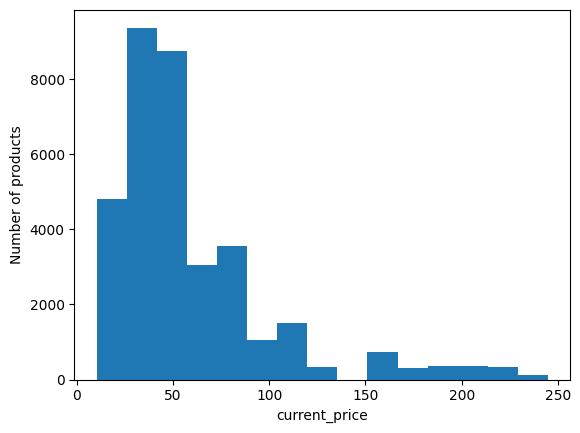

In [28]:
histogram_numeric(dataFrame, 'current_price', bins=15,xname='Top'+str(top_num)+" Brand names", yname='Number of products')

In [30]:
def barplot(df, col, lim=10,xname=None, yname=None):
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.xlabel(xname)
    plt.show()

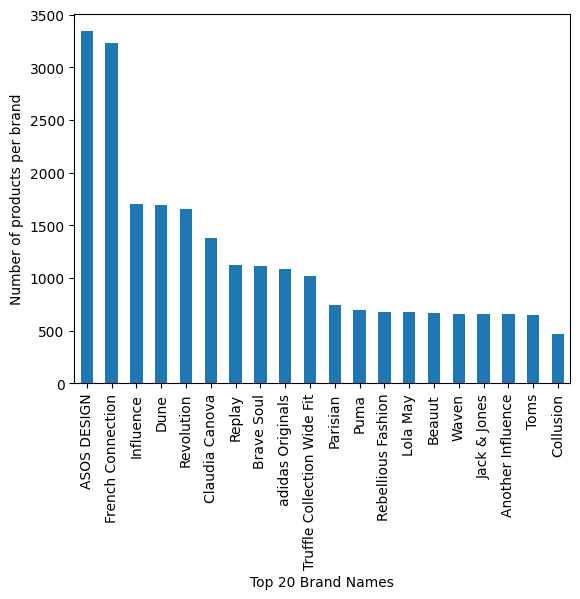

In [32]:
top_num = 20
barplot(dataFrame, 'brand_name', lim=top_num, xname='Top '+str(top_num)+' Brand Names',yname='Number of products per brand')

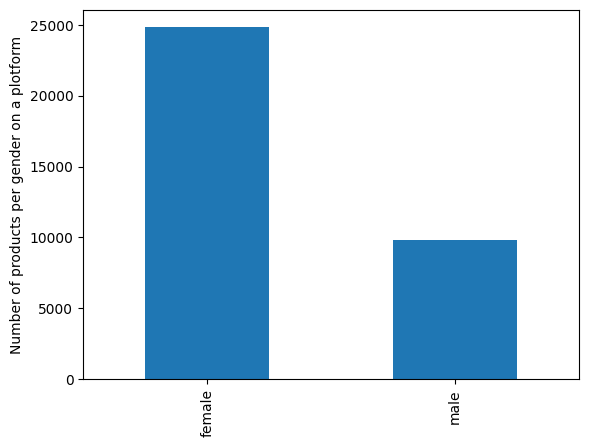

In [53]:
top_num = 10
barplot(dataFrame, 'gender', lim=top_num,yname='Number of products per gender on a plotform')

In [136]:
from pyspark.sql.functions import percentile_approx

def lineplot(df, x, y):  
        
    pd_df = df.groupBy(x).mean(y).toPandas().sort_values(by='avg({})'.format(y))
    
    pd_df.plot.line(x, 'avg({})'.format(y), legend=True,figsize=(12,6))
    # plt.xticks(list(pd_df[x]))
    plt.ylabel(y)
    # plt.figure(figsize=(1000,1000))
    plt.xticks(np.arange(k.shape[0]),list(pd_df[x]),rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

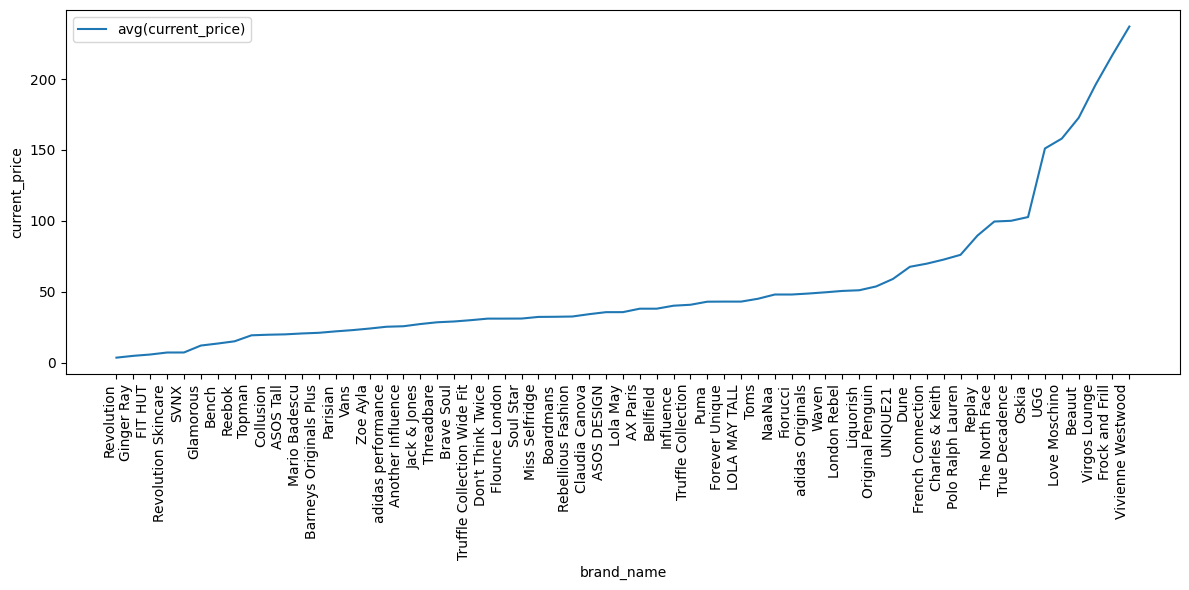

In [137]:
lineplot(dataFrame, 'brand_name', 'current_price')

In [88]:
dataFrame

DataFrame[_id: string, brand_name: string, colour: double, currency: string, current_price: double, gender: string, previous_price: double, productCode: int, productType: string, product_id: int, rrp: double, title: string]

In [127]:
# k = dataFrame.groupBy("brand_name").mean("current_price").toPandas().sort_values(by='avg({})'.format("current_price"))

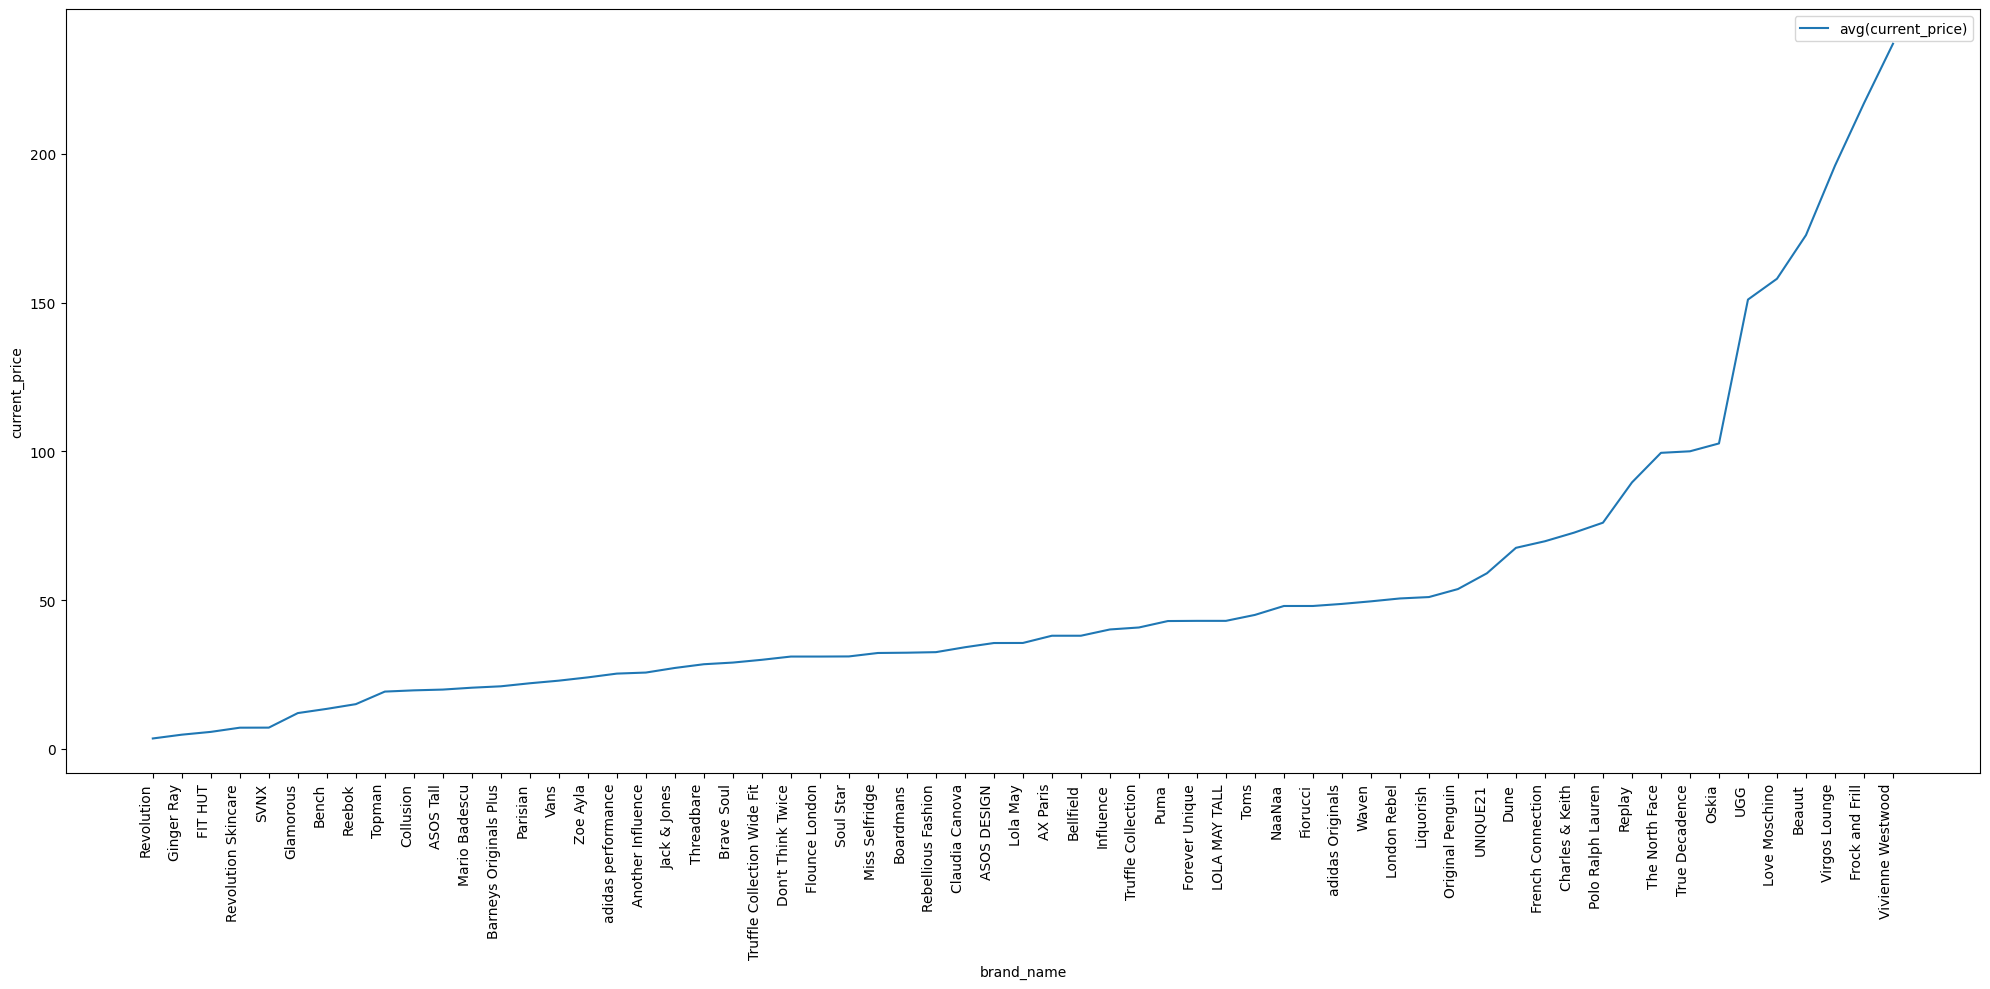

In [133]:
# k.plot.line("brand_name", 'avg({})'.format("current_price"), legend=True,figsize=(20,10))
# # plt.xticks(list(pd_df[x]))
# plt.ylabel("current_price")
# # plt.figure(figsize=(1000,1000))
# plt.xticks(np.arange(k.shape[0]),list(k["brand_name"]),rotation=90, ha='right')
# plt.tight_layout()
# plt.show()

In [138]:
spark.stop()